<a href="https://colab.research.google.com/github/anish170805/ML-projects/blob/main/Ecommerce_product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-commerce product recommendations using catboost**
E-commerce platforms use product recommendations to enhance customer experience and increase sales. CatBoost is a gradient boosting algorithm designed to efficiently handle categorical data and missing values making it ideal for this task. It works by combining decision trees and correcting errors from previous trees to create a strong predictive model. In this article we'll use CatBoost to build a product recommendation system predicting items a customer is likely to be interested in based on their browsing and purchase history.

### **Importing Libraries**

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

### **Loading the dataset**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Online-Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### **Data Exploration**

In [ ]:
print(df.info())
print(df.describe())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000   

checking missing values

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### **Data Preprocessing**
- Drop rows with missing values
- Convert InvoiceDate to datetime
- Create a new column for total price
- Filter out negative quantities
- Change the dtype of CustomerId to integer

In [ ]:
df.dropna(inplace=True)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(np.int64)

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df = df[df['Quantity'] > 0]

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


### **Feature Engineering**
Feature engineering is a technique where we engineer new features based on existing features. We'll create features like the recency, frequency and monetary value (RFM) for each customer.

- reference_date is set to one day after the latest invoice date
Groups data by CustomerID to calculate RFM metrics
- Recency: Days since last purchase
- Frequency: Number of unique invoices
- Monetary: Total spending (TotalPrice)
- Renames columns to 'Recency', 'Frequency', 'Monetary'
- rfm.head() shows the first few rows of the RFM table

In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


### **Train-Test Split**

In [ ]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = np.where(rfm['Monetary'] > rfm['Monetary'].median(), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3471, 3), (868, 3), (3471,), (868,))

### **Parameters for Hyperparameter Tuning**

In [ ]:
param_grid = {
    'iterations': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [2, 4, 6, 8]
}

print(param_grid)

{'iterations': [50, 100, 150, 200], 'learning_rate': [0.01, 0.1, 0.2], 'depth': [2, 4, 6, 8]}


### **Applying GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

cat_model = CatBoostClassifier(verbose=False, random_state=42)

grid_search = GridSearchCV(estimator=cat_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1) # Use all available cores

grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")

GridSearchCV completed.


### **Model Training**

In [ ]:
best_params = grid_search.best_params_

best_cat_model = CatBoostClassifier(**best_params, verbose=False, random_state=42)
best_cat_model.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", best_params)
print("New CatBoostClassifier model trained with best parameters.")

Best parameters found by GridSearchCV: {'depth': 6, 'iterations': 50, 'learning_rate': 0.01}
New CatBoostClassifier model trained with best parameters.


### **Model Evaluation**

In [ ]:
accuracy = best_cat_model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


### **Visualize Feature Importance**

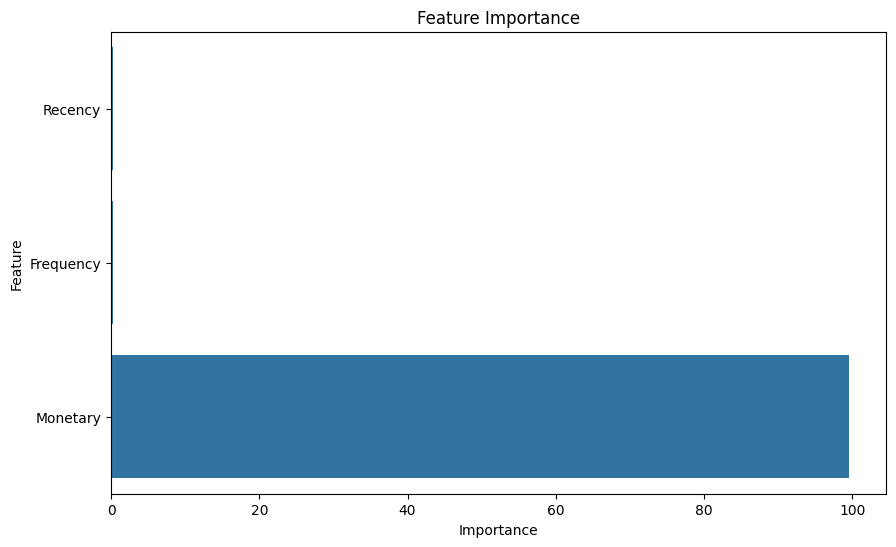

In [ ]:
feature_importance = best_cat_model.get_feature_importance()
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

### **Interactive GUI with ipywidgets**

In [ ]:
import ipywidgets as widgets
from IPython.display import display

recency_input = widgets.IntSlider(min=0, max=365, step=1, description='Recency')
frequency_input = widgets.IntSlider(min=0, max=100, step=1, description='Frequency')
monetary_input = widgets.FloatSlider(min=0, max=10000, step=0.01, description='Monetary')

output = widgets.Output()

def make_prediction(recency, frequency, monetary):
    data = pd.DataFrame({'Recency': [recency], 'Frequency': [frequency], 'Monetary': [monetary]})
    prediction = best_cat_model.predict(data)[0]
    return "Recommend" if prediction == 1 else "Do not recommend"

def update_prediction(change):
    with output:
        output.clear_output()
        prediction = make_prediction(recency_input.value, frequency_input.value, monetary_input.value)
        print(f'Recommendation: {prediction}')

recency_input.observe(update_prediction, names='value')
frequency_input.observe(update_prediction, names='value')
monetary_input.observe(update_prediction, names='value')

display(recency_input, frequency_input, monetary_input, output)

IntSlider(value=0, description='Recency', max=365)

IntSlider(value=0, description='Frequency')

FloatSlider(value=0.0, description='Monetary', max=10000.0, step=0.01)

Output()

**Conclusion**: *The model is just like a toy, not giving much valid answers, the model is highly overfitted the data causing to just depend on Monetary. Fine-Tuning with other parameters can work*